In [1]:
from moarchiving.moarchive import MOArchive
from moarchiving.moarchiving_utils import my_lexsort
from point_sampling import get_non_dominated_points

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import time
import numpy as np
import os
import copy


In [2]:
def plot_performance(f_name=None, plot_function="add", poly_degree=2, xlabel="Archive size",
                     ylabel="Time [s]", title="", logx=True, logy=True, colors=None):
    if f_name is None:
        f_names = os.listdir("test_results")
        f_names = [f for f in f_names if plot_function in f]
        f_names.sort()
        f_name = f_names[-1]

    df = pd.read_csv(f"test_results/{f_name}", index_col=0)

    if colors is None:
        colors = list(mcolors.TABLEAU_COLORS.keys())

    fig, ax = plt.subplots()

    for i, col in enumerate(df.columns):
        # make polynomial fit ignoring the nan values
        y = df[col]
        # shorten the data to the first nan value
        if np.isnan(y).any():
            idx = np.where(np.isnan(y))[0][0]
            y = y[:idx]
        x = df.index[:len(y)]

        # p = np.polyfit(x, y, poly_degree)
        ax.plot(x, y, '-o', label=col, color=colors[i])
        # ax.plot(x, np.polyval(p, x), '--', color=colors[i], alpha=0.4,
        #         label=f"{p[0]:.2E} x^{poly_degree} + O(x^{poly_degree-1})")

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")
    plt.legend()
    plt.grid()
    plt.title(f"{plot_function}: ({f_name[(len(plot_function)+1):-4]}) \n{title}")
    plt.show()


In [3]:
def save_results(data, index, n_dim, function):
    df = pd.DataFrame(data, index=index)
    date = time.strftime("%m%d-%H%M%S")
    df.to_csv(f"test_results/{function}_{n_dim}D_{date}.csv")

In [4]:
def test_add(test_archive_sizes, n_repeats=10, n_dim=3, time_limit=10):
    ref_point = [1] * n_dim

    times = []
    archive_sizes_tested = []
    print("TEST ADD", n_dim)
    print(f"{'num points':10} | {'one by one':10} |")

    for archive_size in test_archive_sizes:
        moa = [MOArchive(get_non_dominated_points(archive_size, n_dim=n_dim), ref_point, n_obj=n_dim)
               for _ in range(n_repeats)]

        add_points = get_non_dominated_points(n_repeats, n_dim=n_dim)
        t0 = time.time()
        for i in range(n_repeats):
            moa[i].add(add_points[i])
        t1 = time.time()

        times.append((t1 - t0) / n_repeats)
        archive_sizes_tested.append(archive_size)

        print(f"{archive_size:10} | {t1 - t0:.8f} |")
        if t1 - t0 > time_limit:
            break
    
    save_results(data={"times": times}, index=archive_sizes_tested, n_dim=n_dim, function="add")



# Test adding points to the archive

TEST ADD 3
num points | one by one |
         1 | 0.00000000 |
         2 | 0.00000000 |
         4 | 0.00099659 |
         8 | 0.00000000 |
        16 | 0.00099730 |
        32 | 0.00199533 |
        64 | 0.00299215 |
       128 | 0.00797868 |
       256 | 0.01699042 |
       512 | 0.02792430 |
      1024 | 0.06383371 |
      2048 | 0.12620115 |
      4096 | 0.22938633 |
      8192 | 0.47548151 |
     16384 | 1.03082871 |
     32768 | 2.19081759 |
     65536 | 4.16966271 |
    131072 | 8.52158046 |
    262144 | 17.45218968 |


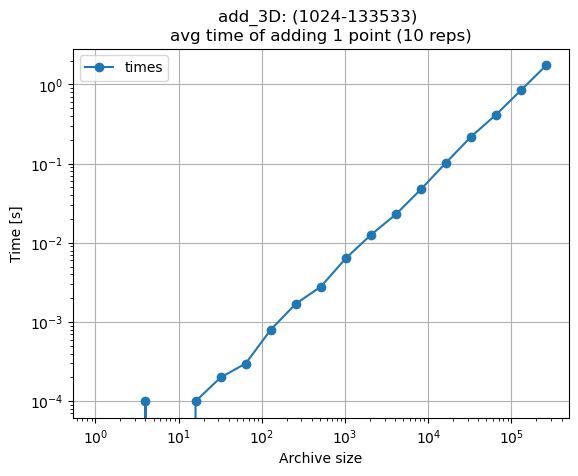

TEST ADD 4
num points | one by one |
         1 | 0.00102520 |
         2 | 0.00099802 |
         4 | 0.00099635 |
         8 | 0.00199866 |
        16 | 0.00498629 |
        32 | 0.02493286 |
        64 | 0.05685449 |
       128 | 0.23634267 |
       256 | 0.61925554 |
       512 | 2.47261810 |
      1024 | 9.23734236 |
      2048 | 31.26960087 |


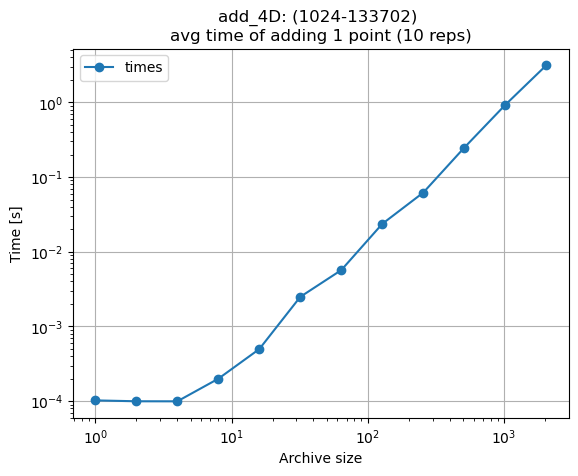

In [5]:
archive_sizes = [2 ** i for i in range(21)]

test_add(test_archive_sizes=archive_sizes, n_dim=3, time_limit=10)
plot_performance(plot_function="add_3D", title="avg time of adding 1 point (10 reps)")

test_add(test_archive_sizes=archive_sizes, n_dim=4, time_limit=10)
plot_performance(plot_function="add_4D", title="avg time of adding 1 point (10 reps)")


# Compare the time of adding different amount of points to the archive

In [6]:
def test_add_n_points(test_archive_sizes, test_n_points, n_dim=3, time_limit=10):
    ref_point = [1] * n_dim

    times_one_by_one = {
        n_points: [] for n_points in test_n_points
    }
    times_reinitialize = {
        n_points: [] for n_points in test_n_points
    }
    archive_sizes_tested = []
    print("TEST ADD N POINTS", n_dim)
    print(f"{'num points':10} | {'one by one':10} | {'reinit':10} |")

    for archive_size in test_archive_sizes:
        for n_points in test_n_points:
            points = get_non_dominated_points(archive_size, n_dim=n_dim)

            moa_one_by_one = MOArchive(copy.deepcopy(points), ref_point, n_obj=n_dim)

            add_points = get_non_dominated_points(n_points, n_dim=n_dim)
            t0 = time.time()
            moa_one_by_one.add_list(add_points)
            t1 = time.time()

            moa_reinitialize = MOArchive(points + add_points, ref_point, n_obj=n_dim)
            t2 = time.time()

            times_one_by_one[n_points].append(max(t1 - t0, 10e-5))
            times_reinitialize[n_points].append(max(t2 - t1, 10e-5))

        archive_sizes_tested.append(archive_size)
        print(f"{archive_size:10} | {times_one_by_one[test_n_points[-1]][-1]:.8f} | "
              f"{times_reinitialize[test_n_points[-1]][-1]:.8f} |")
        if (times_one_by_one[test_n_points[-1]][-1] > time_limit or
                times_reinitialize[test_n_points[-1]][-1] > time_limit):
            break

    data = {}
    for n_points in test_n_points:
        data[f"one_by_one_{n_points}"] = times_one_by_one[n_points]
        data[f"reinitialize_{n_points}"] = times_reinitialize[n_points]

    save_results(data=data, index=archive_sizes_tested, n_dim=n_dim, function="add_n_points")


TEST ADD N POINTS 3
num points | one by one | reinit     |
         1 | 0.02391648 | 0.00300384 |
         2 | 0.01992154 | 0.00398493 |
         4 | 0.02194071 | 0.00296378 |
         8 | 0.02393389 | 0.00199533 |
        16 | 0.02400780 | 0.00361991 |
        32 | 0.03091717 | 0.00299263 |
        64 | 0.04584599 | 0.00598407 |
       128 | 0.06183457 | 0.00498796 |
       256 | 0.10276175 | 0.01193690 |
       512 | 0.19299102 | 0.01396275 |
      1024 | 0.35605860 | 0.02593064 |
      2048 | 0.70922780 | 0.05189657 |
      4096 | 1.41128683 | 0.10172844 |
      8192 | 3.15066910 | 0.20962787 |
     16384 | 6.11945534 | 0.43017268 |
     32768 | 12.60920906 | 0.90134382 |
     65536 | 27.18961644 | 3.06824923 |
    131072 | 55.38712382 | 7.08502674 |
    262144 | 111.31743813 | 14.87922478 |


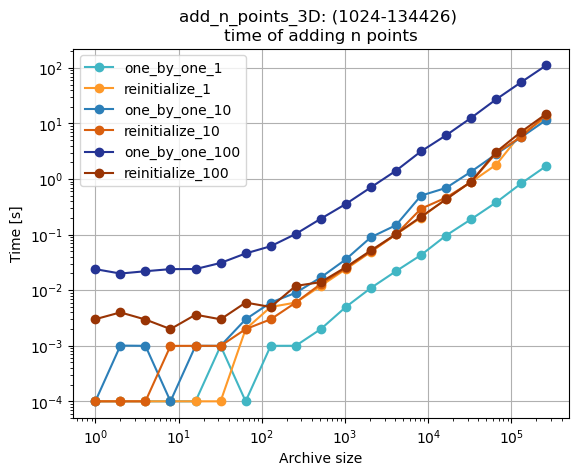

In [7]:
test_add_n_points(test_archive_sizes=archive_sizes, test_n_points=[1, 10, 100],
                  n_dim=3, time_limit=60)
plot_performance(plot_function=f"add_n_points_3D", colors=['#41b6c4', '#fe9929', '#2c7fb8', '#d95f0e', '#253494', '#993404'],
                 title=f"time of adding n points")

In [8]:
def test_kink_points(test_archive_sizes, n_dim=3, time_limit=10):
    print("TEST KINK POINTS")
    times = {
        "spherical": [],
        "linear": [],
    }
    archive_sizes_tested = []
    for archive_size in test_archive_sizes:
        # read the data points and the reference point from the file
        moa = {
            "spherical": MOArchive(get_non_dominated_points(archive_size, mode="spherical", n_dim=n_dim), [1] * n_dim),
            "linear": MOArchive(get_non_dominated_points(archive_size, mode="linear", n_dim=n_dim), [1] * n_dim),
        }
        t0 = time.time()
        moa["spherical"]._get_kink_points()
        
        t1 = time.time()
        moa["linear"]._get_kink_points()
        t2 = time.time()

        times[f"spherical"].append(max(t1 - t0, 10e-5))
        times[f"linear"].append(max(t2 - t1, 10e-5))
        archive_sizes_tested.append(archive_size)
        print(f"{archive_size:10} | {t2-t1:.8f} |")

        if times[f"spherical"][-1] > time_limit or times[f"linear"][-1] > time_limit:
            break
    
    save_results(data=times, index=archive_sizes_tested, n_dim=n_dim, function="kink_points")


TEST KINK POINTS
         1 | 0.00000000 |
         2 | 0.00000000 |
         4 | 0.00101805 |
         8 | 0.00100613 |
        16 | 0.00099730 |
        32 | 0.00199413 |
        64 | 0.00598454 |
       128 | 0.00994062 |
       256 | 0.02293754 |
       512 | 0.05784512 |
      1024 | 0.08872914 |
      2048 | 0.18553662 |
      4096 | 0.37396765 |
      8192 | 0.90757585 |
     16384 | 1.59576774 |
     32768 | 3.23138976 |
     65536 | 7.46407962 |
    131072 | 14.88620090 |


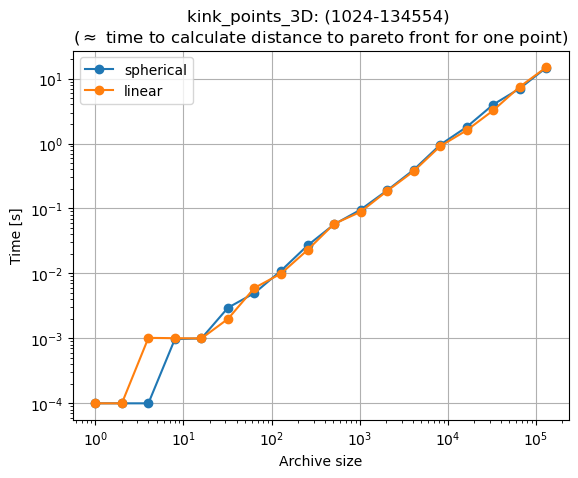

TEST KINK POINTS
         1 | 0.00000000 |
         2 | 0.00000000 |
         4 | 0.00099707 |
         8 | 0.00598550 |
        16 | 0.01798248 |
        32 | 0.06283188 |
        64 | 0.33909297 |
       128 | 1.06418681 |
       256 | 3.59435964 |
       512 | 13.38042927 |


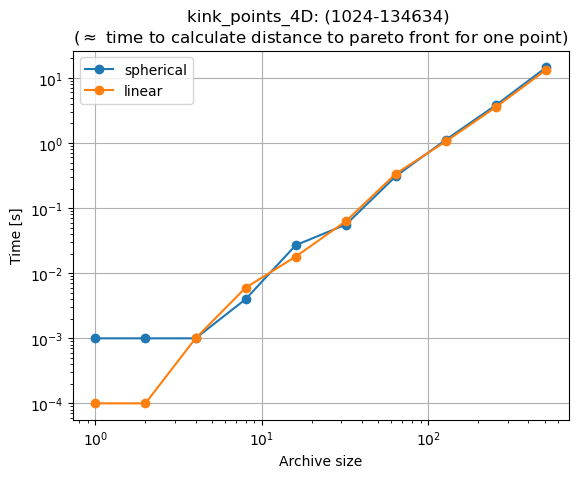

In [9]:
test_kink_points(archive_sizes, n_dim=3, time_limit=10)
plot_performance(plot_function="kink_points_3D", poly_degree=1,
                 title=r"($\approx$ time to calculate distance to pareto front for one point)")

test_kink_points(archive_sizes, n_dim=4, time_limit=10)
plot_performance(plot_function="kink_points_4D", poly_degree=2,
                 title=r"($\approx$ time to calculate distance to pareto front for one point)")


In [10]:
def test_lexsort(test_archive_sizes, n_dim=3):
    time_np = []
    time_my = []

    print("TEST LEXSORT")
    print(f"{'num points':10} | {'my lexsort':10} | {'np lexsort':10} |")
    for n in test_archive_sizes:
        pts = np.random.rand(n, n_dim)
        t0 = time.time()
        my_lexsort([pts[:, i] for i in range(n_dim)])
        t1 = time.time()
        np.lexsort([pts[:, i] for i in range(n_dim)])
        t2 = time.time()

        time_my.append(max(t1 - t0, 10e-5))
        time_np.append(max(t2 - t1, 10e-5))
        print(f"{n:10} | {t1-t0:.8f} | {t2-t1:.8f} |")
    
    save_results(data={"my_lexsort": time_my, "np_lexsort": time_np},
                 index=test_archive_sizes, n_dim=n_dim, function="lexsort")

TEST LEXSORT
num points | my lexsort | np lexsort |
         1 | 0.00000000 | 0.00000000 |
         2 | 0.00000000 | 0.00000000 |
         4 | 0.00100708 | 0.00000000 |
         8 | 0.00000000 | 0.00000000 |
        16 | 0.00000000 | 0.00000000 |
        32 | 0.00000000 | 0.00000000 |
        64 | 0.00000000 | 0.00000000 |
       128 | 0.00000000 | 0.00000000 |
       256 | 0.00098515 | 0.00000000 |
       512 | 0.00000000 | 0.00000000 |
      1024 | 0.00099611 | 0.00000000 |
      2048 | 0.00299168 | 0.00000000 |
      4096 | 0.00797987 | 0.00099659 |
      8192 | 0.01595807 | 0.00099659 |
     16384 | 0.04590583 | 0.00299358 |
     32768 | 0.07975864 | 0.00698018 |
     65536 | 0.17463803 | 0.01698470 |
    131072 | 1.85002589 | 0.03590369 |
    262144 | 1.04917264 | 0.07679296 |
    524288 | 2.54658103 | 0.17054033 |
   1048576 | 4.55086660 | 0.43480659 |


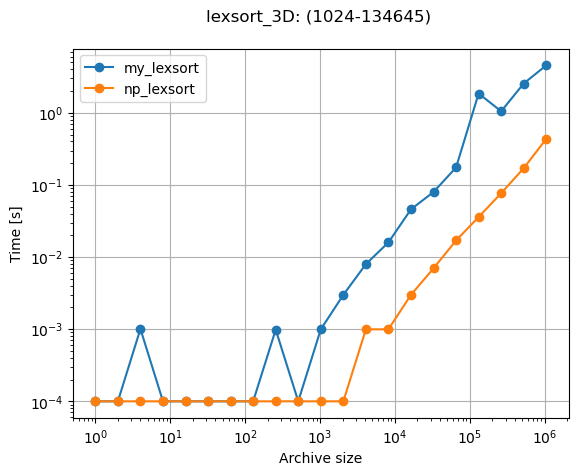

TEST LEXSORT
num points | my lexsort | np lexsort |
         1 | 0.00000000 | 0.00000000 |
         2 | 0.00000000 | 0.00000000 |
         4 | 0.00000000 | 0.00000000 |
         8 | 0.00000000 | 0.00000000 |
        16 | 0.00000000 | 0.00000000 |
        32 | 0.00000000 | 0.00000000 |
        64 | 0.00000000 | 0.00000000 |
       128 | 0.00100493 | 0.00000000 |
       256 | 0.00000000 | 0.00000000 |
       512 | 0.00098991 | 0.00000000 |
      1024 | 0.00099730 | 0.00000000 |
      2048 | 0.00498700 | 0.00000000 |
      4096 | 0.00498629 | 0.00099730 |
      8192 | 0.01097083 | 0.00199437 |
     16384 | 0.02194190 | 0.00398874 |
     32768 | 0.05385709 | 0.00897503 |
     65536 | 0.13364363 | 0.02194047 |
    131072 | 0.49543452 | 0.04886961 |
    262144 | 1.10803866 | 0.10668302 |
    524288 | 2.32546973 | 0.23437858 |
   1048576 | 4.89092517 | 0.59344673 |


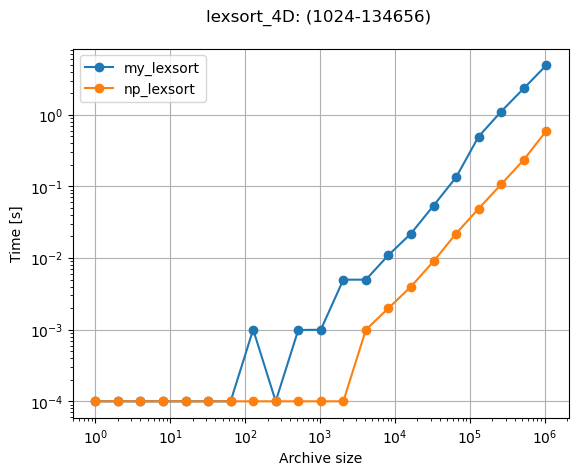

In [11]:
test_lexsort(archive_sizes, n_dim=3)
plot_performance(plot_function="lexsort_3D")

test_lexsort(archive_sizes, n_dim=4)
plot_performance(plot_function="lexsort_4D")

## Contributing hypervolume

In [12]:
def test_contributing_hypervolume(test_archive_sizes, n_dim=3, n_reps=10, time_limit=10):
    times = {
        "naive_spherical": [],
        "naive_linear": []
    }

    print("TEST CONTRIBUTING HYPERVOLUME")
    archive_sizes_tested = []
    for n_points_archive in test_archive_sizes:
        points = {
            "spherical": get_non_dominated_points(n_points_archive, mode="spherical", n_dim=n_dim),
            "linear": get_non_dominated_points(n_points_archive, mode="linear", n_dim=n_dim),
        }
        moa = {
            "spherical": MOArchive(points["spherical"], [1] * n_dim),
            "linear": MOArchive(points["linear"], [1] * n_dim),
        }
        
        t0 = time.time()
        _ = [moa["spherical"].contributing_hypervolume(p) for p in points["spherical"]]
        t1 = time.time()
        _ = [moa["linear"].contributing_hypervolume(p) for p in points["linear"]]
        t2 = time.time()
        
        times["naive_spherical"].append(max((t1 - t0) / n_reps, 10e-5))
        times["naive_linear"].append(max((t2 - t1) / n_reps, 10e-5))
        archive_sizes_tested.append(n_points_archive)

        print(f"{n_points_archive:10} | {times[f'naive_spherical'][-1]:.8f} | {times[f'naive_linear'][-1]:.8f} |")
        if t1 - t0 > time_limit or t2 - t1 > time_limit:
            break
    
    save_results(data=times, index=archive_sizes_tested, n_dim=n_dim, function="contributing_hypervolume")


TEST CONTRIBUTING HYPERVOLUME
         1 | 0.00010000 | 0.00010000 |
         2 | 0.00010000 | 0.00010000 |
         4 | 0.00010000 | 0.00010254 |
         8 | 0.00010000 | 0.00010000 |
        16 | 0.00049856 | 0.00059566 |
        32 | 0.00289509 | 0.00219402 |
        64 | 0.01087141 | 0.00957386 |
       128 | 0.05694809 | 0.04527907 |
       256 | 0.24663732 | 0.22520106 |
       512 | 1.38891258 | 1.11123729 |


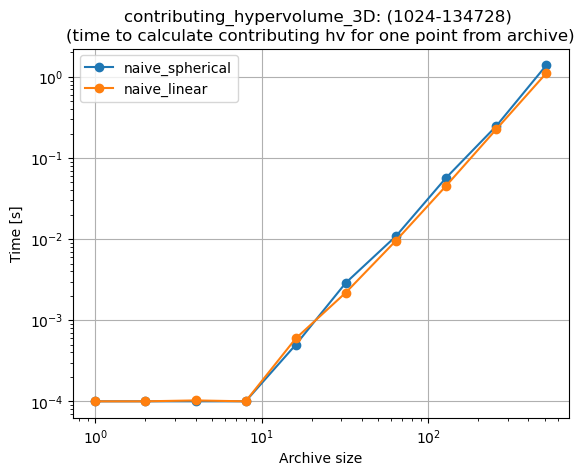

TEST CONTRIBUTING HYPERVOLUME
         1 | 0.00010000 | 0.00010000 |
         2 | 0.00010000 | 0.00010000 |
         4 | 0.00019944 | 0.00010000 |
         8 | 0.00019948 | 0.00029919 |
        16 | 0.00139625 | 0.00159903 |
        32 | 0.00967388 | 0.00867367 |
        64 | 0.06642234 | 0.07409878 |
       128 | 0.43593469 | 0.54284873 |
       256 | 3.29010751 | 3.38464813 |


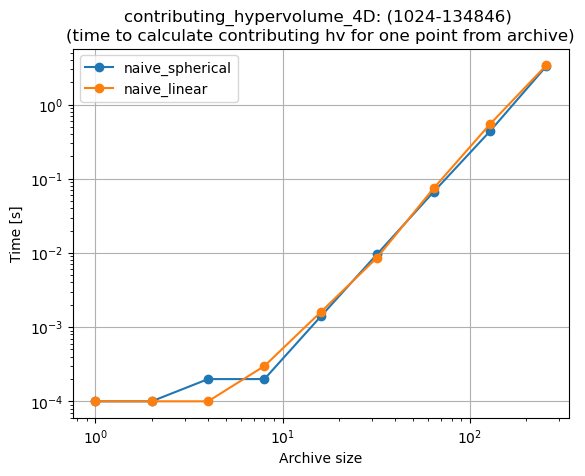

In [13]:
test_contributing_hypervolume(archive_sizes, n_dim=3, time_limit=10)
plot_performance(plot_function="contributing_hypervolume_3D",
                 title="(time to calculate contributing hv for one point from archive)")

test_contributing_hypervolume(archive_sizes, n_dim=4, time_limit=10)
plot_performance(plot_function="contributing_hypervolume_4D",
                 title="(time to calculate contributing hv for one point from archive)")

## Hypervolume improvement

In [14]:
def test_hypervolume_improvement(test_archive_sizes, time_limit=10, n_dim=3, n_reps=10):

    print("TEST HYPERVOLUME IMPROVEMENT")
    times = {
        "times_spherical": [],
        "times_linear": [],
    }
    archive_sizes_tested = []
    for n_points_archive in test_archive_sizes:
        moa = {
            "spherical": MOArchive(get_non_dominated_points(n_points_archive, mode="spherical", n_dim=n_dim), [1] * n_dim),
            "linear": MOArchive(get_non_dominated_points(n_points_archive, mode="linear", n_dim=n_dim), [1] * n_dim)
        }
        new_points = {
            "spherical": get_non_dominated_points(n_reps, mode="spherical", n_dim=n_dim),
            "linear": get_non_dominated_points(n_reps, mode="linear", n_dim=n_dim)
        }
                
        t0 = time.time()
        _ = [moa["spherical"].hypervolume_improvement(p) for p in new_points["spherical"]]
        t1 = time.time()
        _ = [moa["linear"].hypervolume_improvement(p) for p in new_points["linear"]]
        t2 = time.time()

        times["times_spherical"].append(max((t1 - t0) / n_reps, 10e-5))
        times[f"times_linear"].append(max((t2 - t1) / n_reps, 10e-5))
        archive_sizes_tested.append(n_points_archive)
                
        print(f"{n_points_archive:10} | {times['times_spherical'][-1]:.8f} | {times['times_linear'][-1]:.8f} |")

        if t1 - t0 > time_limit or t2 - t1 > time_limit:
            break
    
    save_results(data=times, index=archive_sizes_tested, n_dim=n_dim, function="hypervolume_improvement")

TEST HYPERVOLUME IMPROVEMENT
         1 | 0.00010000 | 0.00010000 |
         2 | 0.00010000 | 0.00010000 |
         4 | 0.00010000 | 0.00010000 |
         8 | 0.00010000 | 0.00010000 |
        16 | 0.00010000 | 0.00010000 |
        32 | 0.00010000 | 0.00010000 |
        64 | 0.00010000 | 0.00010000 |
       128 | 0.00010011 | 0.00019941 |
       256 | 0.00039897 | 0.00039916 |
       512 | 0.00099435 | 0.00070078 |
      1024 | 0.00149596 | 0.00149622 |
      2048 | 0.00359337 | 0.00379047 |
      4096 | 0.01017277 | 0.00678198 |
      8192 | 0.02463446 | 0.01306474 |
     16384 | 0.04827101 | 0.05325751 |
     32768 | 0.13563421 | 0.12267525 |
     65536 | 0.28014791 | 0.26070316 |
    131072 | 0.53736386 | 0.44690189 |
    262144 | 0.99474063 | 1.10793805 |


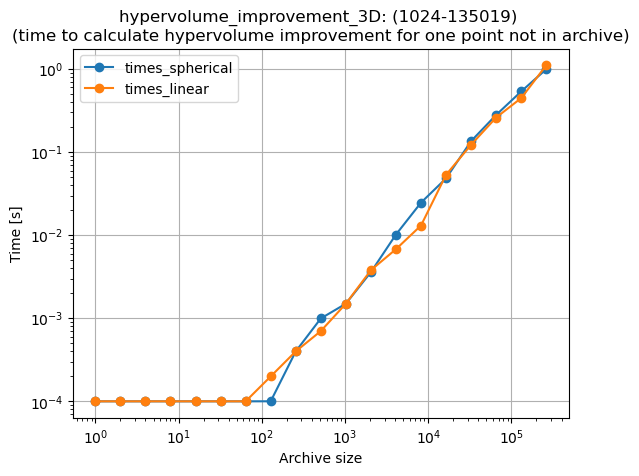

TEST HYPERVOLUME IMPROVEMENT
         1 | 0.00010000 | 0.00010000 |
         2 | 0.00010000 | 0.00019946 |
         4 | 0.00010000 | 0.00019944 |
         8 | 0.00029917 | 0.00039897 |
        16 | 0.00099730 | 0.00089762 |
        32 | 0.00299199 | 0.00299201 |
        64 | 0.00997660 | 0.01007309 |
       128 | 0.04886611 | 0.03610346 |
       256 | 0.11848655 | 0.12675776 |
       512 | 0.48669887 | 0.48281245 |
      1024 | 1.74074967 | 1.59493606 |


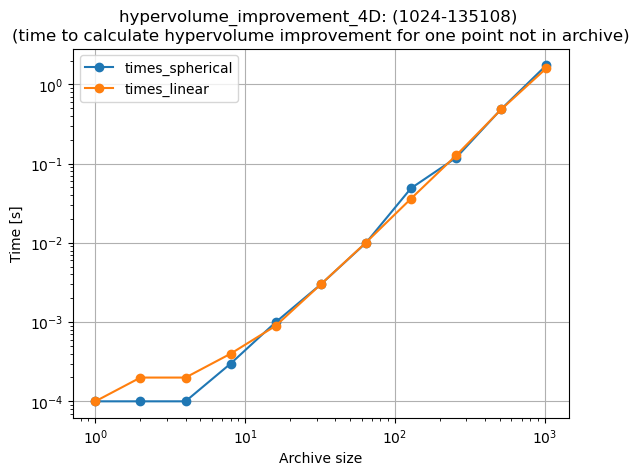

In [15]:
test_hypervolume_improvement(archive_sizes, time_limit=10, n_dim=3)
plot_performance(plot_function="hypervolume_improvement_3D",
                 title="(time to calculate hypervolume improvement for one point not in archive)")

test_hypervolume_improvement(archive_sizes, time_limit=10, n_dim=4)
plot_performance(plot_function="hypervolume_improvement_4D",
                 title="(time to calculate hypervolume improvement for one point not in archive)")